In [1]:
from google.colab import drive
drive.mount('/content/drive');

!cp -r "/content/drive/Othercomputers/My PC/fixed_net/unet" /content

Mounted at /content/drive


In [1]:
from tqdm import tqdm
from unet import UNet
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np
from skimage.io import imshow
import random
from pathlib import Path
import pickle as pickle
import os
from training_data import TrainingDataManager

## Generate Training Data

100%|██████████| 10000/10000 [00:19<00:00, 522.08it/s]


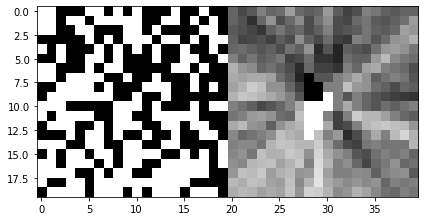

In [57]:
## generate training data
num_data = 10000
size = (20,20);
center = [s/2 for s in size];
line_map = {};

for i in range(size[0]):
  for j in range(size[1]):
    hit_rects = [];
    line_end = (i+0.5,j+0.5);
    for t in range(size[0]):
      for l in range(size[1]):
        # from https://gist.github.com/ChickenProp/3194723
        p_1 = line_end[0]-center[0];
        p_2 = -p_1;
        p_3 = line_end[1]-center[1];
        p_4 = -p_3;
        p = [p_1,p_2,p_3,p_4];

        q_1 = center[0] - t;
        q_2 = t+1 - center[0];
        q_3 = center[1] - l;
        q_4 = l+1 - center[1];
        q = [q_1,q_2,q_3,q_4];
        miss = False;

        if t==l and i ==1 and j == -1:
          print(t,l);
          print(p,q);

        for qk,pk in zip(q,p):
          if (qk < 0 and pk == 0):
            miss = True;
            break;
        if t==l and i == 1 and j == -1:
          print(miss);
        if miss:
          continue;

        u_1 = -max([qk/pk for qk,pk in zip(q,p) if pk < 0])
        u_2 = -min([qk/pk for qk,pk in zip(q,p) if pk > 0]);
        # print(u_1,u_2);
        if u_1 >= u_2 and u_1 > 0 and u_2 <= 1:
          hit_rects.append((t,l));
        if t==l and i == 1 and j == -1:
          print(u_1,u_2);
        
    line_map[(i,j)] = hit_rects;

dataset = []
for i in tqdm(range(num_data)):
  in_im = np.random.default_rng().integers(0,2,size=(2,*size),dtype=np.uint8)
  out_im = np.ones(shape=(1,*size),dtype=np.float32);
  for x in range(size[0]):
    for y in range(size[1]):
      collisions = 0;
      for pixel in line_map[(x,y)]:
        if (in_im[0][pixel]):
          collisions += 1;
        if (in_im[1][pixel]):
          collisions += 5;
      out_im[0,x,y] = (collisions/len(line_map[(x,y)]));
  # print(in_im.shape,out_im.shape);
  dataset.append([Tensor(in_im).to('cuda'),Tensor(out_im).to('cuda')]);

imshow(np.hstack([im.cpu()[0,:,:] for im in random.choice(dataset)]));

## Load Training Data

C:\Users\Harrison Truscott\Documents\GitHub\AI_game_router\memories\smb1Py\run_10_fitness_history\gen_1526
80


# Train Net

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss = None;
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        pred = model(X)

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
    print(f"Train loss: {loss:>7f}");




def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            # print(X.shape);
            pred = model(X)
            # print(y);
            test_loss += loss_fn(pred, y).item()
            # correct += np.array(pred-y).mean();

    test_loss /= num_batches
    # correct /= size
    print(f"Test loss: {test_loss:>8f} \n")

In [6]:
batch_size = 64
test_percent = 0.1
n_train = int((1-0.1)*len(dataset))
n_test = len(dataset) - n_train;

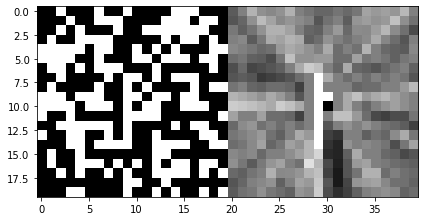

In [58]:
training_data, test_data = random_split(dataset,[n_train, n_test], generator=torch.Generator().manual_seed(0));
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X,y = next(iter(train_dataloader));
imshow(np.hstack([X.cpu()[0,0,:,:],y.cpu()[0,0,:,:]]))

In [47]:
model = UNet(1,1);
model.to('cuda');

In [64]:
epochs = 20
learning_rate = 1e-1

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(model.down[0].maxpool_conv[1].double_conv[0].to('cuda').weight);
# print(model.inc.double_conv[0].weight)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.55it/s]


Train loss: 0.008435


100%|██████████| 16/16 [00:00<00:00, 40.83it/s]


Test loss: 0.008543 

Epoch 2
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.57it/s]


Train loss: 0.007937


100%|██████████| 16/16 [00:00<00:00, 40.58it/s]


Test loss: 0.008310 

Epoch 3
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.38it/s]


Train loss: 0.007602


100%|██████████| 16/16 [00:00<00:00, 40.03it/s]


Test loss: 0.008138 

Epoch 4
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.21it/s]


Train loss: 0.007336


100%|██████████| 16/16 [00:00<00:00, 39.66it/s]


Test loss: 0.007999 

Epoch 5
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 17.99it/s]


Train loss: 0.007104


100%|██████████| 16/16 [00:00<00:00, 39.54it/s]


Test loss: 0.007879 

Epoch 6
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 17.98it/s]


Train loss: 0.006897


100%|██████████| 16/16 [00:00<00:00, 39.82it/s]


Test loss: 0.007777 

Epoch 7
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.23it/s]


Train loss: 0.006717


100%|██████████| 16/16 [00:00<00:00, 39.93it/s]


Test loss: 0.007688 

Epoch 8
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.35it/s]


Train loss: 0.006548


100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Test loss: 0.007609 

Epoch 9
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.45it/s]


Train loss: 0.006392


100%|██████████| 16/16 [00:00<00:00, 40.64it/s]


Test loss: 0.007535 

Epoch 10
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.51it/s]


Train loss: 0.006246


100%|██████████| 16/16 [00:00<00:00, 40.39it/s]


Test loss: 0.007469 

Epoch 11
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.48it/s]


Train loss: 0.006106


100%|██████████| 16/16 [00:00<00:00, 40.04it/s]


Test loss: 0.007409 

Epoch 12
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.40it/s]


Train loss: 0.005978


100%|██████████| 16/16 [00:00<00:00, 39.83it/s]


Test loss: 0.007355 

Epoch 13
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.33it/s]


Train loss: 0.005858


100%|██████████| 16/16 [00:00<00:00, 40.12it/s]


Test loss: 0.007305 

Epoch 14
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.28it/s]


Train loss: 0.005741


100%|██████████| 16/16 [00:00<00:00, 40.39it/s]


Test loss: 0.007258 

Epoch 15
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.24it/s]


Train loss: 0.005638


100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Test loss: 0.007215 

Epoch 16
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.25it/s]


Train loss: 0.005529


100%|██████████| 16/16 [00:00<00:00, 40.03it/s]


Test loss: 0.007171 

Epoch 17
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.30it/s]


Train loss: 0.005438


100%|██████████| 16/16 [00:00<00:00, 39.70it/s]


Test loss: 0.007125 

Epoch 18
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.31it/s]


Train loss: 0.005411


100%|██████████| 16/16 [00:00<00:00, 39.78it/s]


Test loss: 0.007218 

Epoch 19
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.34it/s]


Train loss: 0.005247


100%|██████████| 16/16 [00:00<00:00, 40.24it/s]


Test loss: 0.007067 

Epoch 20
-------------------------------


100%|██████████| 141/141 [00:07<00:00, 18.37it/s]


Train loss: 0.005335


100%|██████████| 16/16 [00:00<00:00, 40.04it/s]

Test loss: 0.007246 

Done!


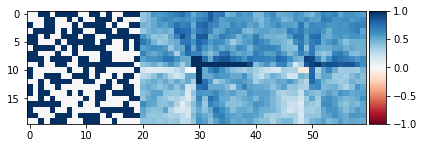

In [65]:
X,y = next(iter(test_dataloader));
pred = model(X);
idx = random.randint(0,X.shape[0]-1);
imshow(np.hstack([X.cpu().detach()[idx,0,:,:],y.cpu().detach()[idx,0,:,:],pred.cpu().detach()[idx,0,:,:]]));

In [63]:
#test 1: lr 1e-2, MSEloss
#test 2: lr 1e-2, BCEWithLogits
#test 3: lr 1e-1, MSEloss
torch.save(model,"test3.model");